In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from corset.data import Dataset
from corset.utils import flatten, makedir
from corset.samplers.discrim import CFTPDiscriminativitySampler

In [4]:
from viz_utils import set_mpl_style, dataset_ordering
    
set_mpl_style()    

In [5]:
def run_experiment_for_dataset(
    dataset_name, min_proba,
    num_samples_per_label=100,
    label_sample_size=50  # number of labels to sample
):
    ds = Dataset(name=dataset_name, datadir='../data')
    ds.load()
    X, Y = ds.trn_X, ds.trn_Y    

    # construct the sampler using the tight proposal distribution
    sampler_tight = CFTPDiscriminativitySampler(proposal_distribution='tight', min_proba=min_proba)
    sampler_tight.build_sample_space_and_generate_rows(X)    
    
    # construct the sampler using the original proposal distribution
    sampler_original = CFTPDiscriminativitySampler(proposal_distribution='original', min_proba=min_proba)

    # hack: copy the sample and new_rows, to avoid recomputing the same results
    sampler_original._sample_space = sampler_tight._sample_space
    sampler_original.new_rows = sampler_tight.new_rows


    # sample using each sampler multiple times and collect sampling information
    samplers = {
        'tight': sampler_tight,
        'orignal': sampler_original
    }    

    result_rows = []
    # sample a set of labels
    label_samples = np.random.permutation(Y.shape[1])[:label_sample_size]
    for label_idx in label_samples:
        y = flatten(Y[:, label_idx].todense())
        
        if len(np.unique(y)) < 2:
            # continue only one class, skip
            continue
            
        sampler_tight.fit(X, y)
        sampler_original.fit(X, y)


        for name, sampler in samplers.items():
            samples_with_details = sampler.sample(
                k=num_samples_per_label,
                return_sample_index=False,
                return_cftp_details=True
            )
            for trial, sample_with_details in enumerate(samples_with_details):
                if sample_with_details is not None:  # converged with a reasonable number of iterations, e.g., 1024
                    details = sample_with_details[1]
                    num_iterations = details['num_iterations']
                else:
                    num_iterations = -1  # does not converge
                    
                result_rows.append(
                    (dataset_name, name, label_idx, trial, num_iterations)
                )
    return pd.DataFrame(result_rows, columns=['dataset', 'proposal', 'label_idx', 'trial', 'num_iters'])

In [6]:
exp_configs = [
    ('mediamill', 0.8),    
    ('Yelp', 0.8),
    ('CAL500', 0.8),
    ('corel5k', .8),        
    ('medical', .95),
    ('bibtex', 0.95),
    ('emotions', 0.5),
    ('birds', 0.95),
    ('birds', .95),
    ('enron', 1.0),
]
df_list = []
for dataset_name, min_proba in exp_configs:
    print(f'experimenting with dataset {dataset_name}')
    df = run_experiment_for_dataset(dataset_name, min_proba)
    df_list.append(df)


experimenting with dataset mediamill


[D 230126 22:59:59 pc:129] confidence graph construction: done
[D 230126 22:59:59 pc:131] converting to connectivity graph: done
[D 230126 22:59:59 pc:106] prune edges from the graph: done
[D 230126 22:59:59 pc:107] number of nodes: 120
[D 230126 22:59:59 pc:108] number of edges change: 6211 -> 815
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 11251.82it/s]
[D 230126 22:59:59 pc:120] running dfs takes: 0.03771376609802246
[D 230126 22:59:59 pc:122] sample space size: 3363
[D 230126 22:59:59 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.03107619285583496


[D 230126 23:00:07 PRETTI_invertedIndex:7] done
[I 230126 23:00:09 assignment:72] sample assignment done


experimenting with dataset Yelp


[D 230126 23:01:05 pc:129] confidence graph construction: done
[D 230126 23:01:07 pc:131] converting to connectivity graph: done
[D 230126 23:01:08 pc:106] prune edges from the graph: done
[D 230126 23:01:08 pc:107] number of nodes: 671
[D 230126 23:01:08 pc:108] number of edges change: 204976 -> 103
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 671/671 [00:00<00:00, 1023038.16it/s]
[D 230126 23:01:08 pc:120] running dfs takes: 0.006267070770263672
[D 230126 23:01:08 pc:122] sample space size: 778
[D 230126 23:01:08 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.0061228275299072266


[D 230126 23:01:20 PRETTI_invertedIndex:7] done
[I 230126 23:01:21 assignment:72] sample assignment done
[D 230126 23:01:23 pc:129] confidence graph construction: done
[D 230126 23:01:23 pc:131] converting to connectivity graph: done


experimenting with dataset CAL500


[D 230126 23:01:23 pc:106] prune edges from the graph: done
[D 230126 23:01:23 pc:107] number of nodes: 68
[D 230126 23:01:23 pc:108] number of edges change: 2210 -> 23
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 243980.04it/s]
[D 230126 23:01:23 pc:120] running dfs takes: 0.0032660961151123047
[D 230126 23:01:23 pc:122] sample space size: 91
[D 230126 23:01:23 PRETTI_invertedIndex:11] building inverted index...
[D 230126 23:01:23 PRETTI_invertedIndex:7] done
[I 230126 23:01:23 assignment:72] sample assignment done


elapsed in dfs_v2_aux: 0.0032269954681396484
experimenting with dataset corel5k


[D 230126 23:01:31 pc:129] confidence graph construction: done
[D 230126 23:01:32 pc:131] converting to connectivity graph: done
[D 230126 23:01:32 pc:106] prune edges from the graph: done
[D 230126 23:01:32 pc:107] number of nodes: 499
[D 230126 23:01:32 pc:108] number of edges change: 49631 -> 0
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 1404669.59it/s]
[D 230126 23:01:32 pc:120] running dfs takes: 0.003863096237182617
[D 230126 23:01:32 pc:122] sample space size: 499
[D 230126 23:01:32 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.0038063526153564453


[D 230126 23:01:34 PRETTI_invertedIndex:7] done
[I 230126 23:01:34 assignment:72] sample assignment done


experimenting with dataset medical


[D 230126 23:01:47 pc:129] confidence graph construction: done
[D 230126 23:01:48 pc:131] converting to connectivity graph: done
[D 230126 23:01:48 pc:106] prune edges from the graph: done
[D 230126 23:01:48 pc:107] number of nodes: 1909
[D 230126 23:01:48 pc:108] number of edges change: 81935 -> 18629
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1909/1909 [00:00<00:00, 5669.62it/s]
[D 230126 23:01:49 pc:120] running dfs takes: 0.41640710830688477


elapsed in dfs_v2_aux: 0.41284894943237305


[D 230126 23:01:50 pc:122] sample space size: 297683
[D 230126 23:01:50 PRETTI_invertedIndex:11] building inverted index...
[D 230126 23:01:54 PRETTI_invertedIndex:7] done
[I 230126 23:02:16 assignment:72] sample assignment done


reaching max number of iters
reaching max number of iters
experimenting with dataset bibtex


[D 230126 23:03:34 pc:129] confidence graph construction: done
[D 230126 23:03:52 pc:131] converting to connectivity graph: done
[D 230126 23:03:54 pc:106] prune edges from the graph: done
[D 230126 23:03:54 pc:107] number of nodes: 1836
[D 230126 23:03:54 pc:108] number of edges change: 1320369 -> 9790
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1836/1836 [00:00<00:00, 8499.59it/s]
[D 230126 23:03:54 pc:120] running dfs takes: 0.26055097579956055


elapsed in dfs_v2_aux: 0.25983691215515137


[D 230126 23:03:55 pc:122] sample space size: 48292
[D 230126 23:03:55 PRETTI_invertedIndex:11] building inverted index...
[D 230126 23:04:31 PRETTI_invertedIndex:7] done
[I 230126 23:04:38 assignment:72] sample assignment done
[D 230126 23:05:13 pc:129] confidence graph construction: done
[D 230126 23:05:13 pc:131] converting to connectivity graph: done
[D 230126 23:05:13 pc:106] prune edges from the graph: done
[D 230126 23:05:13 pc:107] number of nodes: 72
[D 230126 23:05:13 pc:108] number of edges change: 2286 -> 319


experimenting with dataset emotions


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 117597.31it/s]
[D 230126 23:05:13 pc:120] running dfs takes: 0.0042040348052978516
[D 230126 23:05:13 pc:122] sample space size: 497
[D 230126 23:05:13 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.004102945327758789


[D 230126 23:05:13 PRETTI_invertedIndex:7] done
[I 230126 23:05:13 assignment:72] sample assignment done


experimenting with dataset birds


[D 230126 23:05:14 pc:129] confidence graph construction: done
[D 230126 23:05:15 pc:131] converting to connectivity graph: done
[D 230126 23:05:15 pc:106] prune edges from the graph: done
[D 230126 23:05:15 pc:107] number of nodes: 271
[D 230126 23:05:15 pc:108] number of edges change: 24485 -> 1473
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 5038.10it/s]
[D 230126 23:05:15 pc:120] running dfs takes: 0.06324505805969238
[D 230126 23:05:15 pc:122] sample space size: 15298
[D 230126 23:05:15 PRETTI_invertedIndex:11] building inverted index...
[D 230126 23:05:15 PRETTI_invertedIndex:7] done


elapsed in dfs_v2_aux: 0.0630500316619873


[I 230126 23:05:15 assignment:72] sample assignment done


experimenting with dataset birds


[D 230126 23:05:22 pc:129] confidence graph construction: done
[D 230126 23:05:22 pc:131] converting to connectivity graph: done
[D 230126 23:05:22 pc:106] prune edges from the graph: done
[D 230126 23:05:22 pc:107] number of nodes: 271
[D 230126 23:05:22 pc:108] number of edges change: 24485 -> 1473
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 5038.04it/s]
[D 230126 23:05:22 pc:120] running dfs takes: 0.06353998184204102
[D 230126 23:05:22 pc:122] sample space size: 15298
[D 230126 23:05:22 PRETTI_invertedIndex:11] building inverted index...
[D 230126 23:05:22 PRETTI_invertedIndex:7] done


elapsed in dfs_v2_aux: 0.0632009506225586


[I 230126 23:05:22 assignment:72] sample assignment done


experimenting with dataset enron


[D 230126 23:05:46 pc:129] confidence graph construction: done
[D 230126 23:05:52 pc:131] converting to connectivity graph: done
[D 230126 23:05:53 pc:106] prune edges from the graph: done
[D 230126 23:05:53 pc:107] number of nodes: 1001
[D 230126 23:05:53 pc:108] number of edges change: 499511 -> 3071
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:00<00:00, 101747.24it/s]
[D 230126 23:05:53 pc:120] running dfs takes: 0.030190229415893555
[D 230126 23:05:53 pc:122] sample space size: 5152
[D 230126 23:05:53 PRETTI_invertedIndex:11] building inverted index...


elapsed in dfs_v2_aux: 0.03000187873840332


[D 230126 23:05:54 PRETTI_invertedIndex:7] done
[I 230126 23:05:54 assignment:72] sample assignment done


In [16]:
df = pd.concat(df_list, ignore_index=True)

In [17]:
# fraction of sampling trials that converged
converged_df = df[df['num_iters'] > 0]
converged_ratio = converged_df.groupby(['dataset', 'proposal'])['num_iters'].count() / df.groupby(['dataset', 'proposal'])['num_iters'].count()
converged_ratio

dataset    proposal
CAL500     orignal     1.000000
           tight       1.000000
Yelp       orignal     1.000000
           tight       1.000000
bibtex     orignal     1.000000
           tight       1.000000
birds      orignal     1.000000
           tight       1.000000
corel5k    orignal     1.000000
           tight       1.000000
emotions   orignal     1.000000
           tight       1.000000
enron      orignal     1.000000
           tight       1.000000
mediamill  orignal     1.000000
           tight       1.000000
medical    orignal     0.999556
           tight       1.000000
Name: num_iters, dtype: float64

In [18]:
output_path = 'outputs/head-sampling-proposal-distribution-comparison.pkl'
makedir(output_path, usedir=True)
df.to_pickle(output_path)

In [19]:
converged_df['log(num_iters)'] = np.log(converged_df['num_iters'])

summ_df = converged_df.groupby(['dataset', 'proposal'])['log(num_iters)'].mean()

summ_df = summ_df.reset_index()

# rename the proposal distribution name
proposal_name_mapping = {'tight': 'Eq. 17 (used by CORSET)', 'orignal': 'Eq. 16 (used in [23])'}
summ_df = summ_df.assign(**{'proposal-renamed': summ_df['proposal'].apply(lambda v: proposal_name_mapping[v])})

new_legend_title = r'Proposal distribution'
summ_df = summ_df.rename(columns={'proposal-renamed': new_legend_title})

/var/folders/56/m2bm9k3508q4_2f94y87db9c0000gv/T/ipykernel_98387/4231867335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converged_df['log(num_iters)'] = np.log(converged_df['num_iters'])


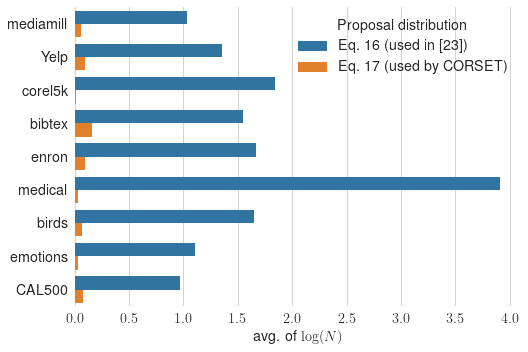

In [20]:


plot = sns.barplot(
    data=summ_df, y='dataset', x='log(num_iters)', hue=new_legend_title,
    order=dataset_ordering
)
fig = plot.figure
ax = fig.axes[0]
ax.set_xlabel(r'avg. of $\log(N)$')
ax.set_ylabel('')
plot.figure.savefig('../plots/proposal-distribution-comparison.pdf')

In [21]:
print(summ_df.to_markdown())

|    | dataset   | proposal   |   log(num_iters) | Proposal distribution   |
|---:|:----------|:-----------|-----------------:|:------------------------|
|  0 | CAL500    | orignal    |        0.964306  | Eq. 16 (used in [23])   |
|  1 | CAL500    | tight      |        0.0726418 | Eq. 17 (used by CORSET) |
|  2 | Yelp      | orignal    |        1.35025   | Eq. 16 (used in [23])   |
|  3 | Yelp      | tight      |        0.0928817 | Eq. 17 (used by CORSET) |
|  4 | bibtex    | orignal    |        1.5471    | Eq. 16 (used in [23])   |
|  5 | bibtex    | tight      |        0.161781  | Eq. 17 (used by CORSET) |
|  6 | birds     | orignal    |        1.65261   | Eq. 16 (used in [23])   |
|  7 | birds     | tight      |        0.0620184 | Eq. 17 (used by CORSET) |
|  8 | corel5k   | orignal    |        1.84462   | Eq. 16 (used in [23])   |
|  9 | corel5k   | tight      |        0.0131557 | Eq. 17 (used by CORSET) |
| 10 | emotions  | orignal    |        1.10904   | Eq. 16 (used in [23])   |

In [22]:
print(summ_df.to_latex(float_format='%.1f'))

\begin{tabular}{lllrl}
\toprule
{} &    dataset & proposal &  log(num\_iters) &    Proposal distribution \\
\midrule
0  &     CAL500 &  orignal &             1.0 &    Eq. 16 (used in [23]) \\
1  &     CAL500 &    tight &             0.1 &  Eq. 17 (used by CORSET) \\
2  &       Yelp &  orignal &             1.4 &    Eq. 16 (used in [23]) \\
3  &       Yelp &    tight &             0.1 &  Eq. 17 (used by CORSET) \\
4  &     bibtex &  orignal &             1.5 &    Eq. 16 (used in [23]) \\
5  &     bibtex &    tight &             0.2 &  Eq. 17 (used by CORSET) \\
6  &      birds &  orignal &             1.7 &    Eq. 16 (used in [23]) \\
7  &      birds &    tight &             0.1 &  Eq. 17 (used by CORSET) \\
8  &    corel5k &  orignal &             1.8 &    Eq. 16 (used in [23]) \\
9  &    corel5k &    tight &             0.0 &  Eq. 17 (used by CORSET) \\
10 &   emotions &  orignal &             1.1 &    Eq. 16 (used in [23]) \\
11 &   emotions &    tight &             0.0 &  Eq. 17 (us

/var/folders/56/m2bm9k3508q4_2f94y87db9c0000gv/T/ipykernel_98387/2909457095.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summ_df.to_latex(float_format='%.1f'))
